# Computing Expected Improvement with a Parametric Mean Field Assumption
## What I Need to Do
- [ ] Need to write code that doesn't allocate much memory when solving the hybrid models log likelihood term.

## Questions
- It still isn't clear to me how we compute the log determinant of our KKT-like system. In the limiting case of the uninformative prior, we have block zero entries in our linear system which seem to push the determinant to 0. 

In [50]:
using Profile
using ProfileView
using BenchmarkTools
using JET
using BayesianOptimization
using GaussianProcesses
using Cthulhu
using PProf
using PDMats

All the necessary imports for our computations of interest

In [99]:
include("../bayesian_optimization.jl")
plotlyjs()

Plots.PlotlyJSBackend()

## Basic Setup

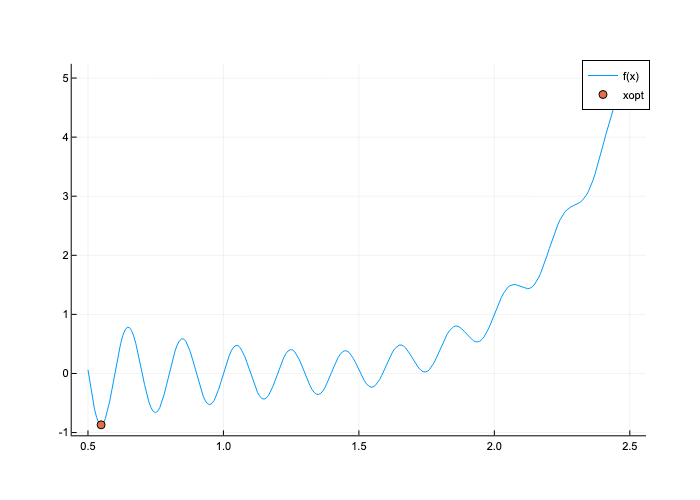

In [100]:
testfn = TestGramacyLee()
# testfn = TestAckley(2)
lbs, ubs = get_bounds(testfn)

polynomial = PolynomialBasisFunction(
    Tuple([ϕ_constant]),
    Tuple([∇ϕ_constant!]),
    Tuple([Hϕ_constant!])
)
polynomial2 = PolynomialBasisFunction(
    get_linear_phi_functions(testfn.dim),
    get_∇linear_phi_functions(testfn.dim),
    get_Hlinear_phi_functions(testfn.dim)
)
polynomial3 = PolynomialBasisFunction(
    Tuple([ϕ_quadratic]),
    Tuple([∇ϕ_quadratic!]),
    Tuple([Hϕ_quadratic!])
)
auto_polynomial = PolynomialBasisFunction(
    Tuple([ϕ_constant, ϕ_quadratic])
)
coefficients = ones(length(polynomial))
coefficients2 = ones(length(polynomial2))
polynomial_trend = PolynomialTrend(polynomial, coefficients, testfn.dim);
polynomial_trend2 = PolynomialTrend(polynomial2, coefficients2, testfn.dim);

M = 64
initial_xs = randsample(M, testfn.dim, lbs, ubs)
minimizers = Vector{Vector{Float64}}(undef, M)
f_minimums = Vector{Float64}(undef, M);
# testfn += polynomial_trend

if testfn.dim < 3 tplot(testfn) end

In [101]:
lbs, ubs = get_bounds(testfn)
domain = lbs[1]:.01:ubs[1]
surrogate_trends, function_trends, initial_observation_sizes = get_trends(0, testfn.dim);

In [102]:
kernel = Matern52()
kernel2 = Matern52([.1])
kernel_lbs, kernel_ubs = [.1], [3.]
θfixed = [0.]
BUDGET = 200

N = 10
# N = length(surrogate_trends[3])
observation_noise = 1e-4
X = randsample(N, testfn.dim, lbs, ubs)
y = testfn(X) + observation_noise * randn(N)
MA = 64

hyperparameter_optimizer_starts = generate_initial_guesses(16, kernel_lbs, kernel_ubs)
inner_optimizer_starts = generate_initial_guesses(MA - 2, lbs, ubs)

S = size(hyperparameter_optimizer_starts, 2)
hyper_minimizers = Vector{Vector{Float64}}(undef, S)
hyper_minimums = Vector{Float64}(undef, S)
initial_xs = randsample(MA, testfn.dim, lbs, ubs)
minimizers = [Vector{Float64}(undef, testfn.dim) for _ in 1:MA]
f_minimums = Vector{Float64}(undef, MA)

# hsur = HybridSurrogate(kernel, polynomial, X, y, decision_rule=EI(),
#     observation_noise=observation_noise, capacity=N + BUDGET)
hsur = HybridSurrogate(kernel, surrogate_trends[3], X, y, N + BUDGET, EI(), observation_noise)
sur = Surrogate(kernel2, X, y, N + BUDGET, EI(), observation_noise);

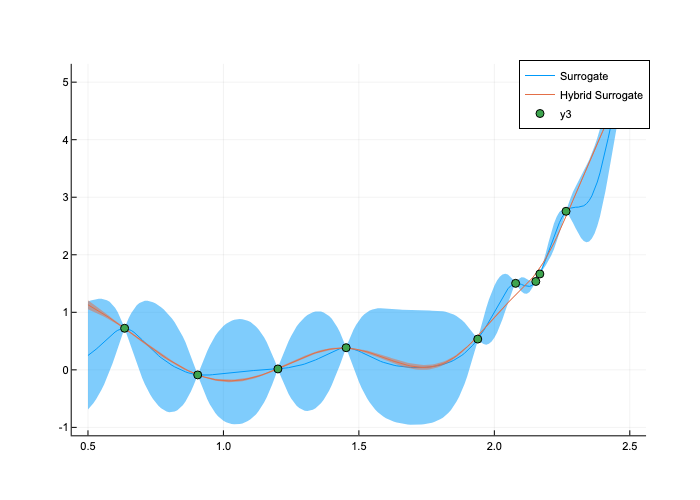

In [103]:
plot(
    domain,
    [predictive_mean(sur, [x]) for x in domain],
    ribbons=[predictive_std(sur, [x]) for x in domain],
    label="Surrogate"
)
plot!(
    domain,
    [predictive_mean(hsur, [x]) for x in domain],
    ribbons=[predictive_std(hsur, [x]) for x in domain],
    label="Hybrid Surrogate"
)
scatter!(get_active_covariates(sur)', get_active_observations(sur))

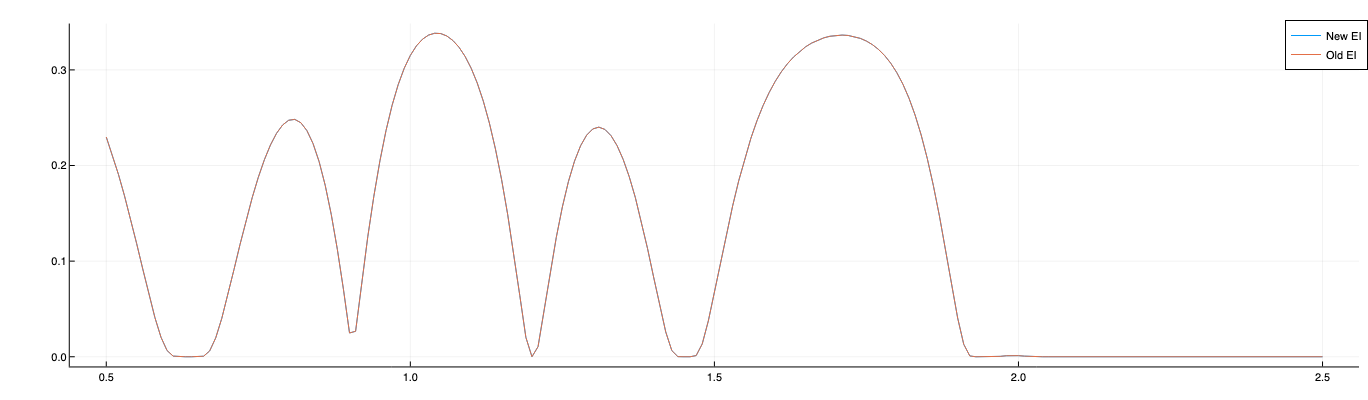

In [104]:
new_ei = ExpectedImprovement(
    minimum(get_active_observations(sur)),
    0.
)
cache = SurrogateEvaluationCache(testfn.dim)
plot(
    domain,
    [
        eval(sur, new_ei, [x], cache) for x in domain
    ], label="New EI")
plot!(domain, [eval(sur([x], [0.])) for x in domain], label="Old EI")

In [106]:
# @benchmark begin
reset_timer!(to)
xnext = zeros(testfn.dim)
hsur = HybridSurrogate(kernel, surrogate_trends[3], X, y, N + BUDGET, EI(), observation_noise)
new_ei = ExpectedImprovement(minimum(get_active_observations(sur)), 0.)
hsur = bayesian_optimize!(
    hsur,
    new_ei,
    testfn,
    lbs,
    ubs,
    kernel_lbs,
    kernel_ubs,
    inner_optimizer_starts,
    hyperparameter_optimizer_starts,
    100,
    minimizers,
    f_minimums,
    hyper_minimizers,
    hyper_minimums,
    xnext
);
# end

Progress: ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [107]:
show(to)

───────────────────────────────────────────────────────────────────────────────────────────
                                                  Time                    Allocations      
                                         ───────────────────────   ────────────────────────
            Tot / % measured:                 18.0s /  99.7%           6.21GiB / 100.0%    

Section                          ncalls     time    %tot     avg     alloc    %tot      avg
───────────────────────────────────────────────────────────────────────────────────────────
Multistart Acquisition Solve        100    15.8s   87.7%   158ms   5.50GiB   88.7%  56.4MiB
Hyperparameter Optimization         100    2.17s   12.1%  21.7ms    714MiB   11.2%  7.14MiB
  NLopt Hypers                    1.80k    2.11s   11.7%  1.17ms    699MiB   11.0%   398KiB
    Set Kernel Hypers             2.75k    1.57s    8.7%   570μs    397MiB    6.2%   148KiB
      Hybrid Coefficient Solve    2.75k    533ms    3.0%   194μs    205MiB    3

In [95]:
show(to)

───────────────────────────────────────────────────────────────────────────────────────────
                                                  Time                    Allocations      
                                         ───────────────────────   ────────────────────────
            Tot / % measured:                 19.2s /  99.6%           6.19GiB / 100.0%    

Section                          ncalls     time    %tot     avg     alloc    %tot      avg
───────────────────────────────────────────────────────────────────────────────────────────
Multistart Acquisition Solve        100    16.3s   85.4%   163ms   5.44GiB   88.0%  55.7MiB
Hyperparameter Optimization         100    2.75s   14.4%  27.5ms    753MiB   11.9%  7.53MiB
  NLopt Hypers                    1.80k    2.69s   14.1%  1.49ms    739MiB   11.7%   420KiB
    Set Kernel Hypers             3.32k    2.10s   11.0%   633μs    419MiB    6.6%   129KiB
      Hybrid Coefficient Solve    3.32k    837ms    4.4%   252μs    217MiB    3

In [109]:
# @benchmark begin
reset_timer!(to)
xnext = zeros(testfn.dim)
sur = Surrogate(kernel2, X, y, N + BUDGET, EI(), observation_noise);
new_ei = ExpectedImprovement(minimum(get_active_observations(sur)), 0.)
sur = bayesian_optimize!(
    sur,
    new_ei,
    testfn,
    lbs,
    ubs,
    kernel_lbs,
    kernel_ubs,
    inner_optimizer_starts,
    hyperparameter_optimizer_starts,
    100,
    minimizers,
    f_minimums,
    hyper_minimizers,
    hyper_minimums,
    xnext
);
# end

Progress: ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [110]:
show(to)

─────────────────────────────────────────────────────────────────────────────────────────
                                                Time                    Allocations      
                                       ───────────────────────   ────────────────────────
           Tot / % measured:                5.81s /  99.2%            923MiB /  99.8%    

Section                        ncalls     time    %tot     avg     alloc    %tot      avg
─────────────────────────────────────────────────────────────────────────────────────────
Multistart Acquisition Solve      100    4.22s   73.2%  42.2ms    613MiB   66.6%  6.13MiB
Hyperparameter Optimization       100    1.54s   26.6%  15.4ms    308MiB   33.4%  3.08MiB
  NLopt Hypers                  1.80k    1.48s   25.7%   822μs    301MiB   32.6%   171KiB
    Set Kernel Hypers           3.70k    1.45s   25.1%   391μs    293MiB   31.9%  81.2KiB
      Set Kernel KXX            3.70k    655ms   11.4%   177μs     0.00B    0.0%    0.00B
      Com

In [98]:
show(to)

─────────────────────────────────────────────────────────────────────────────────────────
                                                Time                    Allocations      
                                       ───────────────────────   ────────────────────────
           Tot / % measured:                7.87s /  99.4%           1.07GiB /  99.8%    

Section                        ncalls     time    %tot     avg     alloc    %tot      avg
─────────────────────────────────────────────────────────────────────────────────────────
Multistart Acquisition Solve      100    6.37s   81.4%  63.7ms    826MiB   75.7%  8.26MiB
Hyperparameter Optimization       100    1.44s   18.4%  14.4ms    265MiB   24.3%  2.65MiB
  NLopt Hypers                  1.80k    1.40s   17.9%   778μs    258MiB   23.6%   147KiB
    Set Kernel Hypers           3.20k    1.37s   17.5%   428μs    252MiB   23.1%  80.6KiB
      Set Kernel KXX            3.20k    629ms    8.0%   197μs     0.00B    0.0%    0.00B
      Com

In [249]:
# @btime begin
f(x) = sum((x .- 1).^2) + randn()                # noisy function to minimize
g(x) = sum((x .+ 1).^2) + randn()

# Choose as a model an elastic GP with input dimensions 2.
# The GP is called elastic, because data can be appended efficiently.
model = ElasticGPE(1,                            # 2 input dimensions
                   mean = MeanConst(0.),         
                   kernel = SEArd([0., 0.], 5.),
                   logNoise = 0.,
                   capacity = BUDGET)              # the initial capacity of the GP is 3000 samples.
set_priors!(model.mean, [Normal(1, 2)])

n=10
x = 2π * rand(n)
model2 = GP(x, y, MeanConst(0.), SEArd([0., 0.], 5.), -1.)
# Optimize the hyperparameters of the GP using maximum a posteriori (MAP) estimates every 50 steps
modeloptimizer = MAPGPOptimizer(every = 1, noisebounds = [-4, 3],       # bounds of the logNoise
                                kernbounds = [[-1, -1, 0], [4, 4, 10]],  # bounds of the 3 parameters GaussianProcesses.get_param_names(model.kernel)
                                maxeval = 100)
opt = BOpt(TestAckley(1),
# opt = BOpt(f,
           model,
           BayesianOptimization.ExpectedImprovement(),                   # type of acquisition
           modeloptimizer,                        
           [-5.], [5.],                     # lowerbounds, upperbounds         
           repetitions = 1,                          # evaluate the function for each input 5 times
           maxiterations = 50,                      # evaluate at 100 input positions
           sense = Min,                              # minimize the function
           acquisitionoptions = (method = :LD_LBFGS, # run optimization of acquisition function with NLopts :LD_LBFGS method
                                 restarts = 64,       # run the NLopt method from 5 random initial conditions each time.
                                 maxtime = 0.1,      # run the NLopt method for at most 0.1 second each time
                                 maxeval = 1000),    # run the NLopt methods for at most 1000 iterations (for other options see https://github.com/JuliaOpt/NLopt.jl)
            verbosity = Progress)
result = boptimize!(opt)
# end

LoadError: MethodError: no method matching fit!(::GPE{Adjoint{Float64, Vector{Float64}}, Vector{Float64}, MeanConst, SEArd{Float64}, GaussianProcesses.FullCovariance, GaussianProcesses.StationaryARDData{Array{Float64, 3}}, PDMat{Float64, Matrix{Float64}}, GaussianProcesses.Scalar{Float64}}, ::Matrix{Float64}, ::Vector{Float64})
The function `fit!` exists, but no method is defined for this combination of argument types.

You might have used a 2d row vector where a 1d column vector was required.
Note the difference between 1d column vector [1,2,3] and 2d row vector [1 2 3].
You can convert to a column vector with the vec() function.

[0mClosest candidates are:
[0m  fit!(::GPE, [91m::AbstractVector[39m, ::AbstractVector)
[0m[90m   @[39m [36mGaussianProcesses[39m [90m~/.julia/packages/GaussianProcesses/dOato/src/[39m[90m[4mGPE.jl:138[24m[39m
[0m  fit!(::GPE{X, Y}, [91m::X[39m, ::Y) where {X, Y}
[0m[90m   @[39m [36mGaussianProcesses[39m [90m~/.julia/packages/GaussianProcesses/dOato/src/[39m[90m[4mGPE.jl:128[24m[39m


In [11]:
@benchmark begin
model = ElasticGPE(1,                            # 2 input dimensions
   mean = MeanConst(0.),         
   kernel = SEArd([0., 0.], 5.),
   logNoise = 0.,
   capacity = BUDGET
)
restarts = 1
options = (method = :LD_LBFGS, restarts = restarts, maxtime = 0.1, maxeval = 100)
strategy = BayesianOptimization.ExpectedImprovement()
opt2 = BayesianOptimization.nlopt_setup(
    strategy,
    model,
    [-5.],
    [5.],
    options
)
# @which BayesianOptimization.acquire_max(opt2, [-5.], [5.], restarts)
BayesianOptimization.acquire_max(strategy, model, [-5.], [5.], options)
end

BenchmarkTools.Trial: 10000 samples with 1 evaluation per sample.
 Range (min … max):  13.708 μs …  2.309 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     31.708 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   30.391 μs ± 25.804 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▁                      ▃▇██▅▃                              
  ▂▇█▆▅▄▅▅▅▄▃▂▂▃▄▃▃▂▂▂▁▁▁▁▅███████▅▅▃▃▃▃▂▃▃▃▃▄▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁ ▃
  13.7 μs         Histogram: frequency by time        52.4 μs <

 Memory estimate: 7.31 KiB, allocs estimate: 129.

In [12]:
@benchmark begin
cache = SurrogateEvaluationCache(testfn.dim)
xstart = vec(randsample(1, testfn.dim, lbs, ubs))
base_solve_nlopt(
    sur,
    ExpectedImprovement(minimum(y), 0.),
    lbs,
    ubs,
    xstart,
    cache
)
end

BenchmarkTools.Trial: 10000 samples with 1 evaluation per sample.
 Range (min … max):   13.791 μs …  37.088 ms  ┊ GC (min … max): 0.00% … 87.95%
 Time  (median):     109.250 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   131.824 μs ± 380.313 μs  ┊ GC (mean ± σ):  2.47% ±  0.88%

    ▆   █▁                                                       
  ▃▄█▆▆▃██▆▅▄▃▃▄▄▄▃▅▄▃▃▅▄▄▄▅▅▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁ ▃
  13.8 μs          Histogram: frequency by time          387 μs <

 Memory estimate: 5.36 KiB, allocs estimate: 155.

In [30]:
using ElasticPDMats

In [57]:
function make_posdef!(m::AbstractMatrix, chol_factors::AbstractMatrix; nugget=0.0)
    copyto!(chol_factors, m)
    chol = cholesky!(Symmetric(chol_factors, :U))
    return m, chol
end

function update_cK!(cK::AbstractPDMat, X::AbstractMatrix, kernel::RadialBasisFunction, s::Surrogate)
    nobs = size(X, 2)
    Σbuffer = cK.mat
    eval_KXX!(kernel, X, Σbuffer, get_diff_x(s))
    for i in 1:nobs
        Σbuffer[i,i] += (JITTER + get_observation_noise(s))
    end
    Σbuffer, chol = make_posdef!(Σbuffer, cK.chol.factors; nugget=0.0)
    # # return wrap_cK(cK, Σbuffer, chol)
    return PDMat(Σbuffer, chol)
end

update_cK2! (generic function with 1 method)

In [63]:
@benchmark begin
    cK = PDMat(get_active_covariance(sur));
    for _ in 1:500
        cK = update_cK!(cK, get_active_covariates(sur), Matern52(), sur)
    end
end

BenchmarkTools.Trial: 21 samples with 1 evaluation per sample.
 Range (min … max):  169.168 ms … 322.710 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     222.877 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   238.245 ms ±  59.843 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁█ ▁▁  ▁▁▁▁▁         █               ▁    ▁     ▁   ▁ ▁   ▁█▁  
  ██▁██▁▁█████▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁█▁▁▁▁▁█▁▁▁█▁█▁▁▁███ ▁
  169 ms           Histogram: frequency by time          323 ms <

 Memory estimate: 476.83 KiB, allocs estimate: 7508.

In [64]:
@benchmark begin
    for _ in 1:500
        set_kernel!(sur, Matern52())
    end
end

BenchmarkTools.Trial: 12 samples with 1 evaluation per sample.
 Range (min … max):  323.053 ms … 524.200 ms  ┊ GC (min … max): 10.22% … 15.25%
 Time  (median):     469.242 ms               ┊ GC (median):     8.43%
 Time  (mean ± σ):   457.166 ms ±  62.311 ms  ┊ GC (mean ± σ):   9.10% ±  7.19%

  █                 █   █            █ █     █ █     █    ███ █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁█▁█▁▁▁▁▁█▁█▁▁▁▁▁█▁▁▁▁███▁█ ▁
  323 ms           Histogram: frequency by time          524 ms <

 Memory estimate: 77.07 MiB, allocs estimate: 10500.